## Entropic approximation of the Nested Distance

Computes on an interactive example the Nested Distance and the Entropic Nested Distance between two scenario trees of depth $T$.

The Nested Distance between stochastic processes is a refinement of the Wasserstein distance to account for proximity in filtrations. We compute the Nested Distance via the backward recursive algorithm introduced in [Kovacevic and Pichler, 2015](https://www-user.tu-chemnitz.de/~alopi/publications/ScenarioTreesKovacevicPichler2015.pdf), which amounts to solve an exponential number (in $T$) number of Linear optimization problems corresponding to the computation of a Wasserstein distance between conditional probabilities, see [Pichler and Schlotter, 2019](https://arxiv.org/abs/1802.03639).

We relax the computation of each Wasserstein distance  by adding an entropic term in the primal objective of the computation of each Wasserstein distance. Thus, the resulting Entropic relaxation of the Nested Distance (END) preserves its main feature: under some assumptions, it is Lipschitz-continuous w.r.t. the value function of Multistage Stochastic optimization Problems, see [Pflug and Pichler, 2012](https://doi.org/10.1137/110825054).

The computation of a Wasserstein cost is done by Linear Programming using the solver Gurobi. By adding an entropic term to the primal of the linear optimization problem associated with the computation of a Wasserstein cost, an alternative maximization scheme in its dual yield Sinkhorn's algorithm, introduced in Optimal Transport in [Cuturi, 2013](https://arxiv.org/abs/1306.0895). By carefully selecting the entropic relaxation term, the complexity of Sinkhorn's algorithm is linear. See [Peyré and Cuturi, 2019](https://arxiv.org/abs/1803.00567) for a complete presentation of Sinkhorn's algorithm.

This notebook aims to highlight the computational efficency of the Entropic Nested Distance compared to the Nested Distance, while remaining its main feature with small over estimation.

In [1]:
using JuMP, Gurobi, ScenTrees, LinearAlgebra

### Packages

JuMP https://github.com/jump-dev/JuMP.jl, for modeling optimization problems,

ScenTrees https://github.com/kirui93/ScenTrees.jl for the introduced Tree julia structure and related functions,

Gurobi https://github.com/jump-dev/Gurobi.jl, interface for Gurobi's solver, using a free academic license, for solving LP.

In [2]:
GUROBI_ENV = Gurobi.Env()


--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only


Gurobi.Env(Ptr{Nothing} @0x0000000005a7a410)

### Wasserstein distance by Linear Programming, using Gurobi

To compare with Hungarian/auction algorithm.

In [3]:
function wasserstein(p1, p2, C)
    """
        Given a cost matrix C,
        Return the optimal transport cost between p1 and p2 reformulated as a LP, 
        see Peyré and Cuturi (2019) p.41 to see more details on how to cast this as a LP in standard form.
    """
    n = length(p1);
    m = length(p2);
    c = vec(C);
    A = vcat(kron(ones(n)', Matrix{Float64}(I, m, m)), kron(Matrix{Float64}(I, n, n), ones(m)'))
    M = Model(optimizer_with_attributes(() -> Gurobi.Optimizer(GUROBI_ENV)))
    set_optimizer_attribute(M, "OutputFlag", 0)
    @variable(M, pp[1:(n*m)])
    @constraint(M, on_p, A*pp .== vcat(p2,p1))
    @constraint(M, positivity, pp .>= 0)
    @objective(M, Min, c'*pp)
    optimize!(M)
    return(objective_value(M))
end

wasserstein (generic function with 1 method)

### Entropic approximation of the Wasserstein distance, following [Cuturi  (2013)](https://arxiv.org/abs/1306.0895) and [Peyré and Cuturi (2019)](https://arxiv.org/abs/1803.00567)

In [21]:
function entropic_wasserstein(p1, p2, C, gamma = 0.009, iter = 300, tranport_plan = 0)
    """
        Given a cost matrix C and a regularization parameter gamma = 0.009 by default.
        Return the optimal transport cost between the probability vectors p1 and p2 after 
        iter = 300 iterations of Sinkhorn's algorithm.
        If transport_plan = 1 (0 by default), then return the optimal transport plan as well.
    """
    G = exp.(-C.*gamma); # Gibbs Kernel.
    u = ones(Float64, length(C[:,1]));
    v = ones(Float64, length(C[1,:]));
    iter = 300;
    for i = 2:iter
         u = p1 ./ (G*v);
         v = p2 ./ (G'*u);
    end
    return(sum(C .* ((diagm(u)*G)*diagm(v))))
end

entropic_wasserstein (generic function with 4 methods)

### Nested Distance, using the decomposition of [Pichler and Schlotter  (2019)](https://arxiv.org/abs/1802.03639)

 Backward computation of the Nested Distance following [Pichler and Schlotter  (2019), Definition 15](https://arxiv.org/abs/1802.03639). 

In [5]:
function nested_distance(tree1::Tree, tree2::Tree, r = 1)
    """
        Computes the Nested Distance between two given trees of same height for parameter r = 1;
    """
    T = height(tree1)+1; # T stage (the root is at height 0)
    C = zeros(Float64, (length(nodes(tree1)), length(nodes(tree2)))); # Alot will remain 0
    # Initialization, computes cost at time T along with useless values that will be changed later on
    C[1,1] = (abs(tree1.state[1] - tree2.state[1]))^r;
    for t in 2:T
        nodes1 = nodes(tree1, t-1); # all nodes at stage t of tree1
        nodes2 = nodes(tree2, t-1);
        for i in nodes1
           for j in nodes2
                C[i,j] = C[tree1.parent[i], tree2.parent[j]] + (abs(tree1.state[i] - tree2.state[j]))^r;
            end
        end
    end
    C.^=(1/r);
    # Recursive, backward in time
    for t in T-1:-1:1 
        nodes1 = nodes(tree1, t-1); 
        nodes2 = nodes(tree2, t-1);
        for i in nodes1
            for j in nodes2
                # strange index in the children function root is implicitly numbered 0, conflict with function root() wich returns 1
                children1 = tree1.children[i+1];
                children2 = tree2.children[j+1];
                C[i,j] = (wasserstein(tree1.probability[children1], 
                    tree2.probability[children2], C[children1, children2]))^(1/r)  
            end
        end
    end
    return(C[1,1])
end

nested_distance (generic function with 2 methods)

 We represent the projection of a discrete time stochastic process $W = (W_1, \ldots, W_T)$
 on the last two coordinates.
 
 We plot how the optimal transport plan from the computation of the Nested Distance $d_{\mathrm{ND}}(W,W')$ transports the mass from $W$ to $W'$.

### Entropic Nested Distance (new)

In [6]:
function entropic_nested_distance(tree1::Tree, tree2::Tree, r = 1, gamma = 100)
    """
        Computes the Nested Distance between two given trees of same height for parameter r = 1; 
        The regularization parameter gamma of the entropic wasserstein distance (Sinkhorn's algorithm)
        is adapted to the cost matrix: gamma = 100/max(cost_ij)
    """
    if gamma == 10 # if not precised by the user, will set gamma s.t. gamma = 100 / max(cost_ij)  
        T = height(tree1)+1; # T stage (the root is at height 0)
        C = zeros(Float64, (length(nodes(tree1)), length(nodes(tree2)))); # Alot will remain 0
        # Initialization, computes cost at time T along with useless values that will be changed later on
        C[1,1] = (abs(tree1.state[1] - tree2.state[1]))^r;
        for t in 2:T
            nodes1 = nodes(tree1, t-1); # all nodes at stage t of tree1
            nodes2 = nodes(tree2, t-1);
            for i in nodes1
               for j in nodes2
                    C[i,j] = C[tree1.parent[i], tree2.parent[j]] + (abs(tree1.state[i] - tree2.state[j]))^r;
                end
            end
        end
        C.^=(1/r);
        # Recursive, backward in time
        for t in T-1:-1:1 
            nodes1 = nodes(tree1, t-1); 
            nodes2 = nodes(tree2, t-1);
            for i in nodes1
                for j in nodes2
                    # strange index in the children function root is implicitly numbered 0, conflict with function root() wich returns 1
                    children1 = tree1.children[i+1];
                    children2 = tree2.children[j+1];
                    gamma = 100 / maximum(C[children1, children2]);
                    C[i,j] = (entropic_wasserstein(tree1.probability[children1], 
                        tree2.probability[children2], C[children1, children2], gamma))^(1/r)  
                end
            end
        end
        return(C[1,1])
    else # use the gamma given by the user
        T = height(tree1)+1; # T stage (the root is at height 0)
        C = zeros(Float64, (length(nodes(tree1)), length(nodes(tree2)))); # Alot will remain 0
        # Initialization, computes cost at time T along with useless values that will be changed later on
        C[1,1] = (abs(tree1.state[1] - tree2.state[1]))^r;
        for t in 2:T
            nodes1 = nodes(tree1, t-1); # all nodes at stage t of tree1
            nodes2 = nodes(tree2, t-1);
            for i in nodes1
               for j in nodes2
                    C[i,j] = C[tree1.parent[i], tree2.parent[j]] + (abs(tree1.state[i] - tree2.state[j]))^r;
                end
            end
        end
        C.^=(1/r);
        # Recursive, backward in time
        for t in T-1:-1:1 
            nodes1 = nodes(tree1, t-1); 
            nodes2 = nodes(tree2, t-1);
            for i in nodes1
                for j in nodes2
                    # strange index in the children function root is implicitly numbered 0, conflict with function root() wich returns 1
                    children1 = tree1.children[i+1];
                    children2 = tree2.children[j+1];
                    C[i,j] = (entropic_wasserstein(tree1.probability[children1], 
                        tree2.probability[children2], C[children1, children2], gamma))^(1/r)  
                end
            end
        end
        return(C[1,1])
    end
end

entropic_nested_distance (generic function with 3 methods)

### Trees generation and visualization, using [Kirui, Pflug and Pichler (2020)](https://joss.theoj.org/papers/10.21105/joss.01912)

In [7]:
# Generates two trees with same depth T and random structure with a bounded number of children per node
T = 5;
max_nb_children = 4;

tree1 = Tree(vcat(1,rand(1:max_nb_children, T-1)), 1);
tree2 = Tree(vcat(1,rand(1:max_nb_children, T-1)), 1);

In [8]:
 entropic_nested_distance(tree1, tree2, 2)

1.0686324838937837

In [9]:
nested_distance(tree1, tree2, 2)
# It is important to run once the function nested_distance function as the solver for LP needs to be loaded
# so in order to have fair running time comparisons later between END and ND, one needs to warm ND up.

1.061389130583242

In [10]:
(entropic_nested_distance(tree1, tree2, 2) - nested_distance(tree1, tree2, 2)) /  entropic_nested_distance(tree1, tree2, 2)

0.006778151908829464

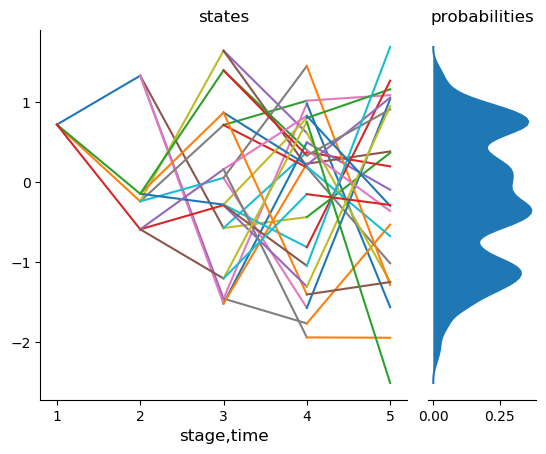

PyObject <matplotlib.collections.PolyCollection object at 0x7f35cd2fb7b8>

In [11]:
# Plotting the first tree
tree_plot(tree1)

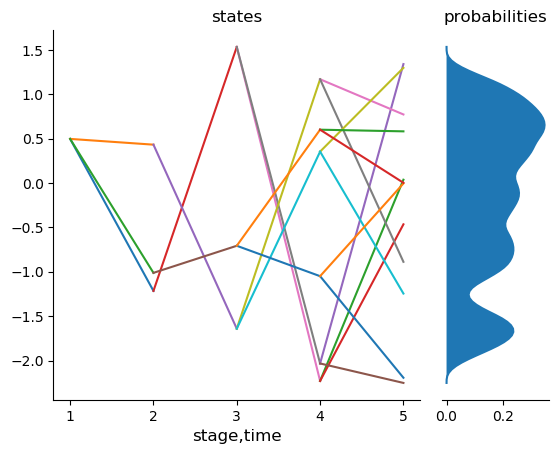

PyObject <matplotlib.collections.PolyCollection object at 0x7f35994e84e0>

In [12]:
# Plotting the second tree
tree_plot(tree2)

### Computation time and relative error of the Nested Distance and the Entropic Nested Distance

In [22]:
T = 6;
max_nb_children = 5;
gamma = 10; # Set gamma != 10 if you want to use your own regularization parameter
r = 2;
itermax = 10;
test = zeros(Float64, itermax);
test2 = zeros(Float64, itermax);
elapsed_0 = zeros(Float64, itermax);
elapsed_1 = zeros(Float64, itermax);
elapsed_2 = zeros(Float64, itermax);

for iter in 1:itermax
    start = time()
    tree1 = Tree(vcat(1,rand(1:max_nb_children, T-1)), 1);
    tree2 = Tree(vcat(1,rand(1:max_nb_children, T-1)), 1);
    elapsed_0[iter] = time() - start;
    start = time()
    test[iter] = entropic_nested_distance(tree1, tree2, r, gamma);
    elapsed_1[iter] = time() - start;
    start = time()
    test2[iter] = nested_distance(tree1, tree2, r);
    elapsed_2[iter] = time() - start
    println("Time Nested Distance = ", elapsed_2[iter])
    println("Time Entropic Nested Distance = ", elapsed_1[iter])
    println("----")
    println("Nested Distance value = ", test2[iter])
    println("Entropic Nested Distance value = ", test[iter])
    println("----")
    println("On this example the computation of the Entropic Nested Distance is ", elapsed_2[iter]/elapsed_1[iter], " faster than the computation of the Nested Distance.")
    println("Absolute error equal to ", abs(test[iter] - test2[iter]))
    println("Relative error equal to ", 100*((test[iter] - test2[iter])/test2[iter]), "%")
    println("----")
    println("----")
end 

Time Nested Distance = 0.11403107643127441
Time Entropic Nested Distance = 0.5442938804626465
----
Nested Distance value = 1.025468433077124
Entropic Nested Distance value = 1.0282628303737043
----
On this example the computation of the Entropic Nested Distance is 0.20950277143360255 faster than the computation of the Nested Distance.
Absolute error equal to 0.0027943972965802644
Relative error equal to 0.27249959203474594%
----
----
Time Nested Distance = 1.8773119449615479
Time Entropic Nested Distance = 0.45166707038879395
----
Nested Distance value = 1.0299400414392328
Entropic Nested Distance value = 1.0331038379970867
----
On this example the computation of the Entropic Nested Distance is 4.156406495044153 faster than the computation of the Nested Distance.
Absolute error equal to 0.003163796557853926
Relative error equal to 0.3071825961279118%
----
----
Time Nested Distance = 14.947983980178833
Time Entropic Nested Distance = 3.0335769653320312
----
Nested Distance value = 1.027

In [17]:
average_speedup = 1/itermax * sum(elapsed_2 ./ elapsed_1);
average_relerror = 1/itermax * sum(100*((test .- test2)./test2));
average_time_ND = 1/itermax * sum(elapsed_2)
average_time_END = 1/itermax * sum(elapsed_1)
println("speedup = ", average_speedup)
println("relative error = ", average_relerror)
println("time ND = ", average_time_ND)
println("time END = ", average_time_END)

speedup = 3.736683198706551
relative error = 0.7378214931708217
time ND = 2.377852988243103
time END = 0.5918396711349487


In [15]:
average_generation = 1/itermax * sum(elapsed_0);
println("tree generation time = ", average_generation)

tree generation time = 0.00043132305145263675


### Visualization of the optimal transport plan for the Nested Distance and Entropic Nested Distance

 We represent the projection of a discrete time stochastic process $W = (W_1, \ldots, W_T)$
 on the last two coordinates.
 
 We plot how the optimal transport plan from the computation of the Entropic Nested Distance $d_{\mathrm{END}}(W,W')$ transports the mass from $W$ to $W'$.
 
 WORK IN PROGRES, TO DO


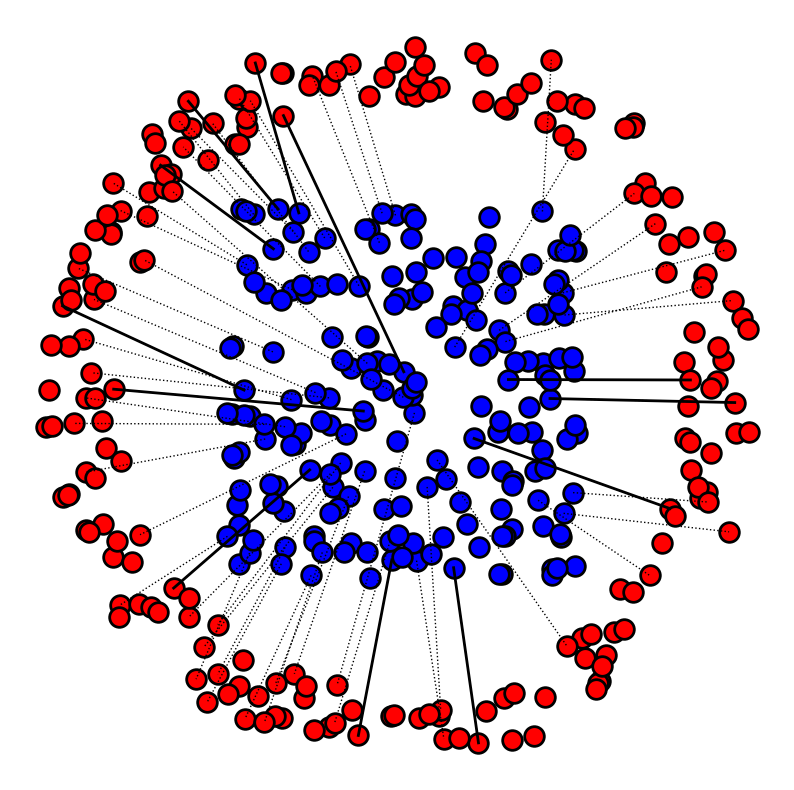

In [16]:
using PyPlot

N = [200,200]; # Number of points in each cloud
d = 2; # Dimension of the clouds.
x = rand(2,N[1]).- 0.5; # Point cloud x, of N1 points inside a square.

# Point cloud y, of N2 points inside an anulus.
theta = 2*pi*rand(1,N[2]);
r = .8 .+ .2*rand(1,N[2]);
y = [cos.(theta).*r; sin.(theta).*r];

# Shortcut for displaying point clouds.
plotp = (x,col) -> scatter(x[1,:], x[2,:], s=200,
 edgecolors="k", c=col, linewidths=2);

# Cost matrix C_{i,j} =‖xi−yj‖2.
x2 = sum(x.^2, dims = 1);
y2 = sum(y.^2,dims =1);
C = repeat(y2,outer=(N[1],1)) + repeat(x2',outer=(1,N[2])) - 2*x'*y;

# Target histograms, here uniform histograms.
p = ones(N[1])/N[1];
q = ones(N[2])/N[2];

gamma = 0.001; # Regularization strength γ.
xi = exp.(-C./gamma); # Gibbs Kernel.
# b = ones(N[2]); # Initialization of b0 (a0 does not need to be initialized).

b = ones(Float64, N[2]);
niter = 300;
Err_p = []
Err_q = []

for i = 2:niter
    global b
    global a
     a = p ./ (xi*b);
     append!(Err_q, norm(b.*(xi'*a) - q)/norm(q));
     b = q ./ (xi'*a);
     append!(Err_p, norm(a.*(xi*b) - p)/norm(p));
end

# figure(figsize = (10,7))
#
# subplot(2,1,1)
# title("norme(pi -p)")
# plot(log.(Array(Err_p) .+ 1e-5), linewidth = 2)
# xlim(0,niter)
#
# subplot(2,1,2)
# title("norme(pi^T -q)")
# plot(log.(Array(Err_q) .+ 1e-5), linewidth = 2)
# xlim(0,niter)

# Optimal transport plan
Pi = (diagm(a)*xi)*diagm(b);

# Plotting the two discrete distributions
figure(figsize=(10,10))
plotp(x, "b")
plotp(y, "r")

# In continuous line, "big" (70% of the mass) links
indices = findall( x -> x > minimum(1 ./ Array(N))*.8, Pi)
premiersPoints = getindex.(indices, 1);
secondPoints = getindex.(indices, 2);
plot([x[1,premiersPoints],y[1,secondPoints]],
    [x[2,premiersPoints],y[2,secondPoints]],"k",lw = 2)

# In dashed line, "medium" (30% of the mass) links
indices = findall( x -> x > minimum(1 ./ Array(N))*.6, Pi)
premiersPoints = getindex.(indices, 1);
secondPoints = getindex.(indices, 2);
plot([x[1,premiersPoints],y[1,secondPoints]],
    [x[2,premiersPoints],y[2,secondPoints]],"k:",lw = 1)

axis("off")
xlim(minimum(y[1,:])-.1,maximum(y[1,:])+.1)
ylim(minimum(y[2,:])-.1,maximum(y[2,:])+.1);